# Dataset Overview

File Counts:
RGB Images: 57580
RGB Labels: 57580
IR Images: 57580
IR Labels: 57580

Sample Filenames:
RGB → ['BIRD_00160_001_png.rf.83d82e1339a851b2e3f37bc0631284d8.jpg', 'BIRD_00160_001_png.rf.f9423fe5f9ef7f4f3419addc319192f4.jpg']
IR  → ['IR_BIRD_00160_001_png.rf.69a4850f48f928d16a41dd24ecb8f454.jpg', 'IR_BIRD_00160_001_png.rf.d4c132ef2f33b3e7677759238a75ea85.jpg']

Image Shapes:
RGB Shape: (256, 320, 3)
IR Shape: (256, 320)

Data Types:
RGB Dtype: uint8
IR Dtype: uint8


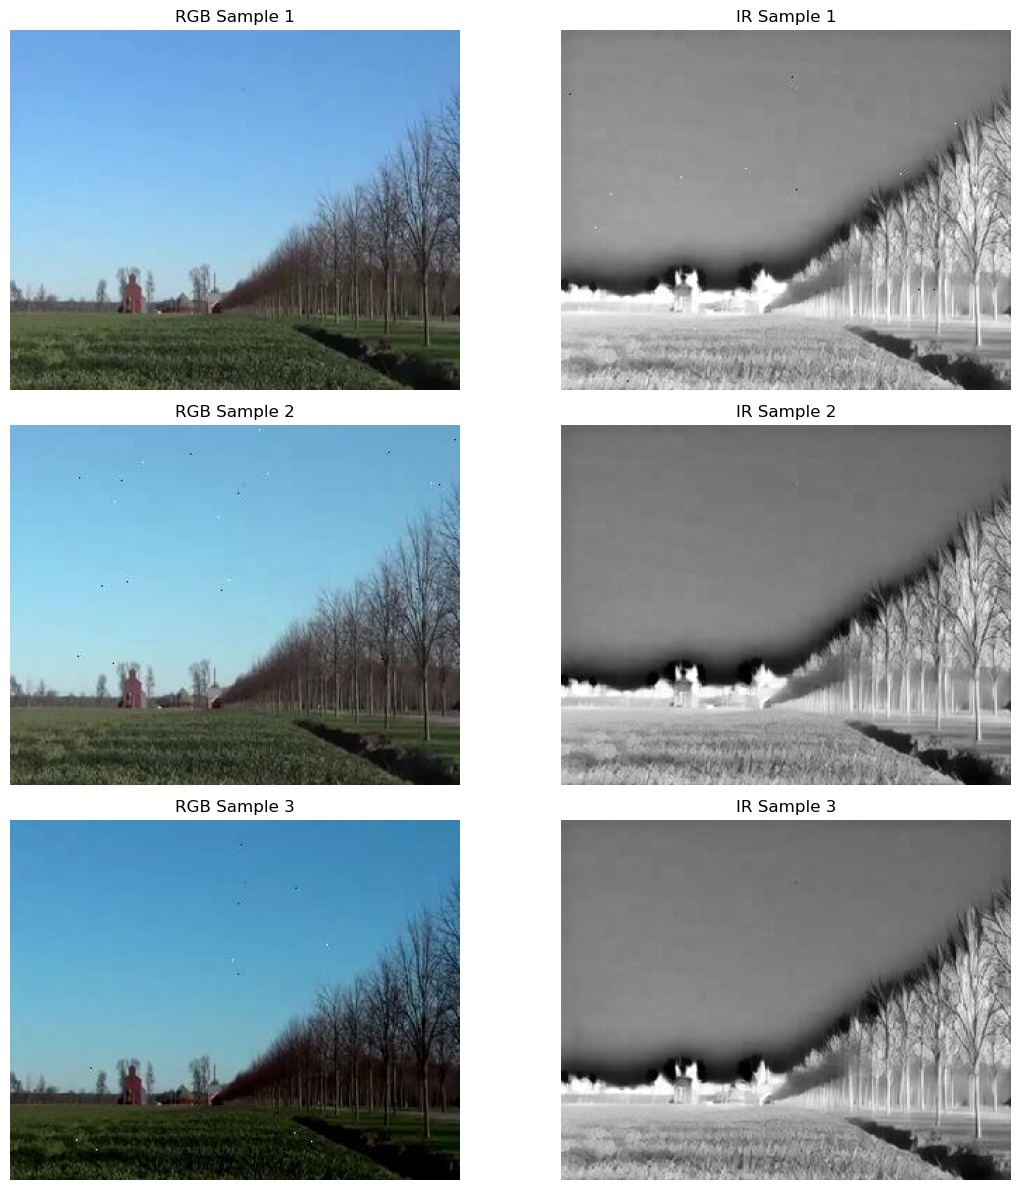


Label Sample (YOLO format):
0 0.5234375 0.169921875 0.04375 0.046875


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from collections import Counter

# Paths to dataset directories
base_path = Path("Dataset")
rgb_img_dir = base_path / "RGB/images"
rgb_lbl_dir = base_path / "RGB/labels"
ir_img_dir = base_path / "IR/images"
ir_lbl_dir = base_path / "IR/labels"

# File Counts
print("File Counts:")
print("RGB Images:", len(list(rgb_img_dir.glob("*.jpg"))))
print("RGB Labels:", len(list(rgb_lbl_dir.glob("*.txt"))))
print("IR Images:", len(list(ir_img_dir.glob("*.jpg"))))
print("IR Labels:", len(list(ir_lbl_dir.glob("*.txt"))))

# Sample File Names Format
print("\nSample Filenames:")
print("RGB →", os.listdir(rgb_img_dir)[1:3])
print("IR  →", os.listdir(ir_img_dir)[1:3])


sample_rgb = cv2.imread(str(next(rgb_img_dir.glob("*.jpg"))))
sample_ir = cv2.imread(str(next(ir_img_dir.glob("*.jpg"))), cv2.IMREAD_GRAYSCALE)

print("\nImage Shapes:")
print("RGB Shape:", sample_rgb.shape)  # Expect (256, 320, 3)
print("IR Shape:", sample_ir.shape)    # Expect (256, 320)

print("\nData Types:")
print("RGB Dtype:", sample_rgb.dtype)
print("IR Dtype:", sample_ir.dtype)

# Visualizing a Few Samples
def plot_rgb_ir_samples(n=3):
    rgb_paths = sorted(glob(str(rgb_img_dir / "*.jpg")))[:n]
    ir_paths = sorted(glob(str(ir_img_dir / "*.jpg")))[:n]
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        rgb = cv2.cvtColor(cv2.imread(rgb_paths[i]), cv2.COLOR_BGR2RGB)
        ir = cv2.imread(ir_paths[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(n,2, 2*i +1)
        plt.imshow(rgb)
        plt.title(f"RGB Sample {i+1}")
        plt.axis("off")

        plt.subplot(n, 2, 2 *i +2)
        plt.imshow(ir, cmap='gray')
        plt.title(f"IR Sample {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_rgb_ir_samples()

# Label Format
label_sample = next(rgb_lbl_dir.glob("*.txt"))
with open(label_sample) as f:
    lines = f.readlines()
print("\nLabel Sample (YOLO format):")
for line in lines[:5]:
    print(line.strip())

In [4]:
# Distribution of Classes
def count_labels(label_dir):
    counts = Counter()
    for file in Path(label_dir).glob("*.txt"):
        with open(file) as f:
            for line in f:
                cls = int(line.strip().split()[0])
                counts[cls] += 1
    return counts

rgb_class_dist = count_labels(rgb_lbl_dir)
ir_class_dist = count_labels(ir_lbl_dir)

print("\nClass Distribution (RGB):", dict(rgb_class_dist))
print("Class Distribution (IR):", dict(ir_class_dist))



Class Distribution (RGB): {0: 28226, 1: 36670}
Class Distribution (IR): {0: 28226, 1: 36670}


# Drone Detection
### Objective:
Detect and classify drones vs birds in real-time from `RGB` and `IR` data under various environmental and distortion conditions.


## RGB model

This cell writes the `rgb_dataset.yaml` configuration file used by YOLO11 training.
It sets the dataset path, specifies that train/val/test all use the `images/` folder and defines two classes: 'bird' and 'drone'.

In [2]:
yaml_content = """
path: Dataset/RGB
train: images
val: images
test: images

nc: 2
names: ['bird', 'drone']
"""

with open("rgb_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("Created rgb_dataset.yaml")


Created rgb_dataset.yaml


### This cell checks if a CUDA-capable GPU is available and prints device information.


In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

### This cell loads the pretrained yolo11n model from a `.pt` weights file.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

In [ ]:
# Training the model
model.train(
    data='rgb_dataset.yaml',
    epochs=20,
    imgsz=320,
    batch=64,
    name='rgb_yolo11_model')

Ultralytics 8.3.141  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=rgb_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rgb_yolo11_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

train: Scanning C:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\Dataset\RGB\labels.cache... 57580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57580/57580 [00:00<?, ?it/s]
c:\Users\Admin\anaconda3\envs\DL_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 3.06.6 ms, read: 36.514.0 MB/s, size: 5.3 KB)


val: Scanning C:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\Dataset\RGB\labels.cache... 57580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57580/57580 [00:00<?, ?it/s]


Plotting labels to runs\detect\rgb_yolo11_model\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs\detect\rgb_yolo11_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.13G        2.2      2.339      1.011         83        320: 100%|██████████| 900/900 [02:08<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [04:42<00:00,  1.59it/s]


                   all      57580      64896      0.692      0.698      0.713      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.53G      2.053      1.388     0.9698         66        320: 100%|██████████| 900/900 [02:29<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:16<00:00,  3.31it/s]


                   all      57580      64896      0.826      0.684      0.751      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.53G      2.057      1.308     0.9727         91        320: 100%|██████████| 900/900 [02:23<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [04:19<00:00,  1.74it/s]


                   all      57580      64896      0.841      0.658      0.715      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.53G      2.009      1.244     0.9624         76        320: 100%|██████████| 900/900 [02:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:07<00:00,  3.53it/s]


                   all      57580      64896      0.837      0.702       0.76      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.53G      1.944      1.155       0.95         75        320: 100%|██████████| 900/900 [02:46<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [04:38<00:00,  1.61it/s]


                   all      57580      64896      0.906      0.809      0.864      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.53G      1.882        1.1     0.9413         65        320: 100%|██████████| 900/900 [01:56<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:07<00:00,  3.54it/s]


                   all      57580      64896      0.901      0.833      0.878      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.53G      1.839      1.061     0.9312         70        320: 100%|██████████| 900/900 [01:51<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:23<00:00,  3.13it/s]


                   all      57580      64896      0.907      0.832      0.882      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.53G      1.798      1.025     0.9242         70        320: 100%|██████████| 900/900 [02:38<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:09<00:00,  3.47it/s]


                   all      57580      64896       0.92      0.844        0.9      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.53G      1.748     0.9906     0.9188         79        320: 100%|██████████| 900/900 [01:52<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:07<00:00,  3.53it/s]


                   all      57580      64896      0.913      0.855      0.909      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.53G      1.719     0.9636     0.9147         97        320: 100%|██████████| 900/900 [01:49<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:16<00:00,  3.29it/s]


                   all      57580      64896      0.918      0.877      0.924      0.491
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.53G      1.608     0.8585     0.9185         54        320: 100%|██████████| 900/900 [02:35<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:33<00:00,  2.93it/s]


                   all      57580      64896      0.935      0.869      0.927      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.53G       1.54     0.8139     0.9088         56        320: 100%|██████████| 900/900 [01:52<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:06<00:00,  3.55it/s]


                   all      57580      64896      0.941       0.88      0.935      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.53G      1.479     0.7754     0.8985         49        320: 100%|██████████| 900/900 [01:51<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:07<00:00,  3.53it/s]


                   all      57580      64896      0.944      0.889      0.941      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.53G      1.432     0.7404     0.8922         44        320: 100%|██████████| 900/900 [02:04<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [04:32<00:00,  1.65it/s]


                   all      57580      64896      0.947      0.893      0.945       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.53G      1.379     0.7028     0.8834         47        320: 100%|██████████| 900/900 [02:27<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [03:44<00:00,  2.01it/s]


                   all      57580      64896      0.951        0.9      0.947      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.53G      1.333     0.6745     0.8762         46        320: 100%|██████████| 900/900 [02:37<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [04:09<00:00,  1.80it/s]


                   all      57580      64896      0.953      0.902      0.949      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.53G      1.281     0.6464     0.8695         48        320: 100%|██████████| 900/900 [02:49<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [03:27<00:00,  2.17it/s]


                   all      57580      64896      0.953      0.905      0.951      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.53G      1.236     0.6223     0.8615         47        320: 100%|██████████| 900/900 [01:51<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:05<00:00,  3.58it/s]


                   all      57580      64896      0.955      0.908      0.952      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.53G      1.189      0.597      0.857         52        320: 100%|██████████| 900/900 [02:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [02:16<00:00,  3.31it/s]


                   all      57580      64896      0.956       0.91      0.953      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.53G      1.143     0.5698     0.8497         49        320: 100%|██████████| 900/900 [02:15<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [03:08<00:00,  2.38it/s]


                   all      57580      64896      0.956      0.912      0.955      0.631

20 epochs completed in 1.743 hours.
Optimizer stripped from runs\detect\rgb_yolo11_model\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\rgb_yolo11_model\weights\best.pt, 5.4MB

Validating runs\detect\rgb_yolo11_model\weights\best.pt...
Ultralytics 8.3.141  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 450/450 [05:09<00:00,  1.45it/s]


                   all      57580      64896      0.956      0.912      0.954      0.631
                  bird      20910      28226       0.95      0.854      0.927      0.544
                 drone      36670      36670      0.961       0.97      0.982      0.717
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\rgb_yolo11_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000182B530E290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [19]:
# Evaluate the model after training
metrics = model.val(data='rgb_dataset.yaml')


Ultralytics 8.3.141  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 108.864.3 MB/s, size: 5.5 KB)


val: Scanning C:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\Dataset\RGB\labels.cache... 57580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57580/57580 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 900/900 [03:05<00:00,  4.85it/s]


                   all      57580      64896      0.955      0.912      0.954      0.631
                  bird      20910      28226       0.95      0.854      0.926      0.544
                 drone      36670      36670      0.961       0.97      0.982      0.718
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\rgb_yolo11_model7


In [11]:
class_names = ['bird', 'drone']

print("\nClass-wise Metrics:")
for i, cls in enumerate(class_names):
    p = metrics.box.p[i]
    r = metrics.box.r[i]
    ap50 = metrics.box.ap50[i]
    ap5095 = metrics.box.ap[i]
    print(f"Class: {cls:<6} | Precision: {p:.4f} | Recall: {r:.4f} | mAP@0.5: {ap50:.4f} | mAP@0.5:0.95: {ap5095:.4f}")

# Show overall mAP scores
print("\nSummary:")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")



Class-wise Metrics:
Class: bird   | Precision: 0.9500 | Recall: 0.8538 | mAP@0.5: 0.9262 | mAP@0.5:0.95: 0.5443
Class: drone  | Precision: 0.9611 | Recall: 0.9697 | mAP@0.5: 0.9821 | mAP@0.5:0.95: 0.7177

Summary:
mAP@0.5: 0.9542
mAP@0.5:0.95: 0.6310


### This cell groups image frames into scenes based on filenames, then creates short videos for selected scenes.

In [14]:
import os
import re
import cv2
import random
from glob import glob
from collections import defaultdict

image_dir = "Dataset/RGB/images"
video_output_dir = "SceneVideos"
os.makedirs(video_output_dir, exist_ok=True)


all_images = glob(os.path.join(image_dir, "*.jpg"))
print(f"Found {len(all_images)} images. Examples:")
for i, f in enumerate(all_images[:3]):
    print(f"  {i+1}: {os.path.basename(f)}")


# Example filename: BIRD_00160_001_png.rf.abcd123.jpg
pattern = r"(BIRD|DRONE)_(\d+)_\d+_png"  # Extract class and scene ID

# Group by scene ID
scene_groups = defaultdict(list)
for path in all_images:
    filename = os.path.basename(path)
    match = re.search(pattern, filename)
    if match:
        scene_id = match.group(2)
        scene_groups[scene_id].append(path)

# Show how many scenes found
print(f"\nTotal unique scenes: {len(scene_groups)}")
for scene_id, frames in list(scene_groups.items())[:3]:
    print(f"  Scene {scene_id}: {len(frames)} frames")


scene_groups = {k: sorted(v, key=lambda x: int(x.split("_")[2])) for k, v in scene_groups.items() if len(v) >= 3}

# Select up to 6 random scenes
num_scenes = min(6, len(scene_groups))
if num_scenes == 0:
    raise ValueError("No valid scenes found. Check filename format or image count.")

selected_scenes = random.sample(list(scene_groups.items()), num_scenes)

# Create videos from selected scenes
for scene_id, frames in selected_scenes:
    sample_frame = cv2.imread(frames[0])
    if sample_frame is None:
        print(f"Could not read: {frames[0]}. Skipping scene {scene_id}")
        continue

    height, width, _ = sample_frame.shape
    video_path = os.path.join(video_output_dir, f"Scene_{scene_id}.mp4")
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    for frame_path in frames:
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video saved: {video_path}")


Found 57580 images. Examples:
  1: BIRD_00160_001_png.rf.83d82e1339a851b2e3f37bc0631284d8.jpg
  2: BIRD_00160_001_png.rf.f9423fe5f9ef7f4f3419addc319192f4.jpg
  3: BIRD_00160_002_png.rf.665902ae9388b9016e15cee3a6c03905.jpg

Total unique scenes: 102
  Scene 00160: 278 frames
  Scene 00261: 620 frames
  Scene 00362: 334 frames
Video saved: SceneVideos\Scene_051161.mp4
Video saved: SceneVideos\Scene_066176.mp4
Video saved: SceneVideos\Scene_00362.mp4
Video saved: SceneVideos\Scene_01877.mp4
Video saved: SceneVideos\Scene_021131.mp4
Video saved: SceneVideos\Scene_02685.mp4


### This section runs detection on each video created in the previous step. Outputs are saved as new annotated videos.


In [15]:
from ultralytics import YOLO
import glob
import os


model = YOLO("runs/detect/rgb_yolo11_model/weights/best.pt")


video_folder = "SceneVideos"
video_paths = glob.glob(os.path.join(video_folder, "*.mp4"))

# Run prediction on each video
for video_path in video_paths:
    results = model.predict(
        source=video_path,
        conf=0.3,
        save=True,
        imgsz=320
    )
    print(f"Processed: {video_path}")
    print(f"Output saved to: {results[0].save_dir}")



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/602) c:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\SceneVideos\Scene_002112.mp4: 256x320 1 drone, 5.3ms
video 1/1 (frame 2/602) c:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\SceneVideos\Scene_002112.mp4: 256x320 1 drone, 5.4ms
video 1/1 (frame 3/602) c:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\SceneVideos\Scene_002112.mp4: 256x320 1 drone, 4.2ms
video 1/1 (frame 4/602) c:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\Scen

# IR model
## Same steps

In [ ]:
yaml_content = """
path: Dataset/IR
train: images
val: images
test: images

nc: 2
names: ['bird', 'drone']
"""

with open("IR_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("Created IR_dataset.yaml")

In [ ]:
from ultralytics import YOLO

model2 = YOLO('yolo11n.pt')

In [ ]:
# Training the model
model2.train(
    data='IR_dataset.yaml',
    epochs=20,
    imgsz=320,
    batch=64,
    name='IR_yolo11_model')

In [17]:
# Evaluate the model after training

metrics2 = model2.val(data='IR_dataset.yaml')

Ultralytics 8.3.141  Python-3.11.10 torch-2.5.0 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 28.014.0 MB/s, size: 7.4 KB)


val: Scanning C:\Users\Admin\Albaraa\Projects\IEEE VIP Cup\Code\Dataset\IR\labels.cache... 57580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57580/57580 [00:00<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002C9D35A18A0>
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\envs\DL_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Admin\anaconda3\envs\DL_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3599/3599 [03:12<00:00, 18.65it/s]


                   all      57580      64896      0.967      0.941      0.971      0.628
                  bird      20910      28226      0.953      0.906      0.952      0.551
                 drone      36670      36670      0.981      0.976       0.99      0.705
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val3


In [18]:
class_names = ['bird', 'drone']

print("\nClass-wise Metrics:")
for i, cls in enumerate(class_names):
    p = metrics2.box.p[i]
    r = metrics2.box.r[i]
    ap50 = metrics2.box.ap50[i]
    ap5095 = metrics2.box.ap[i]
    print(f"Class: {cls:<6} | Precision: {p:.4f} | Recall: {r:.4f} | mAP@0.5: {ap50:.4f} | mAP@0.5:0.95: {ap5095:.4f}")

# Show overall mAP scores
print("\nSummary:")
print(f"mAP@0.5: {metrics2.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics2.box.map:.4f}")



Class-wise Metrics:
Class: bird   | Precision: 0.9528 | Recall: 0.9062 | mAP@0.5: 0.9524 | mAP@0.5:0.95: 0.5508
Class: drone  | Precision: 0.9814 | Recall: 0.9759 | mAP@0.5: 0.9902 | mAP@0.5:0.95: 0.7046

Summary:
mAP@0.5: 0.9713
mAP@0.5:0.95: 0.6277


In [ ]:
import os
import re
import cv2
import random
from glob import glob
from collections import defaultdict


image_dir = "Dataset/IR/images"
video_output_dir = "SceneVideos2"
os.makedirs(video_output_dir, exist_ok=True)


all_images = glob(os.path.join(image_dir, "*.jpg"))
print(f"🔍 Found {len(all_images)} images. Examples:")
for i, f in enumerate(all_images[:3]):
    print(f"  {i+1}: {os.path.basename(f)}")


# Example filename: BIRD_00160_001_png.rf.abcd123.jpg
pattern = r"(BIRD|DRONE)_(\d+)_\d+_png"  # Extract class and scene ID

# Group by scene ID
scene_groups = defaultdict(list)
for path in all_images:
    filename = os.path.basename(path)
    match = re.search(pattern, filename)
    if match:
        scene_id = match.group(2)
        scene_groups[scene_id].append(path)


print(f"\nTotal unique scenes: {len(scene_groups)}")
for scene_id, frames in list(scene_groups.items())[:3]:
    print(f"  Scene {scene_id}: {len(frames)} frames")


scene_groups = {k: sorted(v, key=lambda x: int(x.split("_")[2])) for k, v in scene_groups.items() if len(v) >= 3}


num_scenes = min(6, len(scene_groups))
if num_scenes == 0:
    raise ValueError("No valid scenes found. Check filename format or image count.")

selected_scenes = random.sample(list(scene_groups.items()), num_scenes)


for scene_id, frames in selected_scenes:
    sample_frame = cv2.imread(frames[0])
    if sample_frame is None:
        print(f"Could not read: {frames[0]}. Skipping scene {scene_id}")
        continue

    height, width, _ = sample_frame.shape
    video_path = os.path.join(video_output_dir, f"Scene_{scene_id}.mp4")
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

    for frame_path in frames:
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video saved: {video_path}")


In [ ]:
from ultralytics import YOLO
import glob
import os

# Load your trained model
model = YOLO("runs/detect/IR_yolo11_model/weights/best.pt")

# Folder with your generated test videos
video_folder = "SceneVideos2"
video_paths = glob.glob(os.path.join(video_folder, "*.mp4"))

# Run prediction on each video
for video_path in video_paths:
    results = model.predict(
        source=video_path,
        conf=0.3,
        save=True,
        imgsz=320
    )
    print(f"Processed: {video_path}")
    print(f"Output saved to: {results[0].save_dir}")
